In [135]:
options(repr.plot.width=10, repr.plot.height=4)

In [1]:
library(tidyverse)

── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# STATS 504
## Week 14: Predicting air quality

<table class="table table-bordered center" style="width:95%">
	<caption style="text-align:center; font-size: 1.7em;color:black;padding-bottom:5px"><strong>AQI Basics for Ozone and Particle Pollution</strong></caption>
	<thead>
		<tr style="background: rgb(225, 235, 244); color: black;">
			<th scope="col" style="text-align:center;width:15%;vertical-align: text-top;padding:5px;font-size:19px">Daily AQI Color</th>
			<th scope="col" style="text-align:center;width:15%;vertical-align: text-top;padding:5px;font-size:19px">Levels of Concern</th>
			<th scope="col" style="text-align:center;width:15%;vertical-align: text-top;padding:5px;font-size:19px">Values of Index</th>
			<th scope="col" style="text-align:center;width:30%;vertical-align: text-top;padding:5px;font-size:19px">Description of Air Quality</th>
		</tr>
	</thead>
	<tbody>
		<tr style="background: rgb(0, 228, 0); color: black;">
			<td><strong>Green</strong></td>
			<td id="good"><strong>Good</strong></td>
			<td><strong>0 to 50</strong></td>
			<td><strong>Air quality is satisfactory, and air pollution poses little or no risk.</strong></td>
		</tr>
		<tr style="background:yellow; color: black;">
			<td><strong>Yellow</strong></td>
			<td id="mod"><strong>Moderate</strong></td>
			<td><strong>51 to 100</strong></td>
			<td><strong>Air quality is acceptable. However, there may be a risk for some people, particularly those who are unusually sensitive to air pollution.</strong></td>
		</tr>
		<tr style="background: rgb(255, 126, 0); color: black;">
			<td><strong>Orange</strong></td>
			<td id="sens"><strong>Unhealthy for Sensitive Groups</strong></td>
			<td><strong>101 to 150</strong></td>
			<td><strong>Members of sensitive groups may experience health effects. The general public is less likely to be affected.</strong></td>
		</tr>
		<tr style="background:red; color: black;">
			<td><strong>Red</strong></td>
			<td id="unh"><strong>Unhealthy</strong></td>
			<td><strong>151 to 200</strong></td>
			<td><strong>Some members of the general public may experience health effects; members of sensitive groups may experience more serious health effects.</strong></td>
		</tr>
		<tr style="background: rgb(143, 63, 151);color:white;">
			<td><strong>Purple</strong></td>
			<td id="vunh"><strong>Very Unhealthy</strong></td>
			<td><strong>201 to 300</strong></td>
			<td><strong>Health alert: The risk of health effects is increased for everyone.</strong></td>
		</tr>
		<tr style="background: rgb(126, 0, 35 );color:white;">
			<td><strong>Maroon</strong></td>
			<td id="haz"><strong>Hazardous</strong></td>
			<td><strong>301 and higher</strong></td>
			<td><strong>Health warning of emergency conditions: everyone is more likely to be affected.</strong></td>
		</tr>
	</tbody>
</table>

## Calculating AQI

1. Identify the highest concentration among all monitors within each reporting area and truncate as follows:
    - Ozone (ppm): truncate to 3 decimal places  
    - PM2.5 (µg/m³): truncate to 1 decimal place  
    - PM10 (µg/m³): truncate to integer  
    - CO (ppm): truncate to 1 decimal place  
    - SO₂ (ppb): truncate to integer  
    - NO₂ (ppb): truncate to integer  

2. Using the breakpoints table, find the two breakpoints that contain the concentration.

| **AQI**   | **Ozone (ppm, 8-hour)** | **PM2.5 (µg/m³, 24-hour)** | **PM10 (µg/m³, 24-hour)** | **CO (ppm, 8-hour)** | **SO₂ (ppb, 1-hour)** | **NO₂ (ppb, 1-hour)** |
|-----------|--------------------------|----------------------------|---------------------------|-----------------------|-----------------------|-----------------------|
| 0-50      | 0.000–0.054              | 0.0–12.0                  | 0–54                     | 0.0–4.4              | 0–35                  | 0–53                  |
| 51-100    | 0.055–0.070              | 12.1–35.4                 | 55–154                   | 4.5–9.4              | 36–75                 | 54–100                |
| 101-150   | 0.071–0.085              | 35.5–55.4                 | 155–254                  | 9.5–12.4             | 76–185                | 101–360               |
| 151-200   | 0.086–0.105              | 55.5–150.4                | 255–354                  | 12.5–15.4            | 186–304               | 361–649               |
| 201-300   | 0.106–0.200              | 150.5–250.4               | 355–424                  | 15.5–30.4            | 305–604               | 650–1249              |
| 301-400   | 0.201–0.300              | 250.5–350.4               | 425–504                  | 30.5–40.4            | 605–804               | 1250–1649             |
| 401-500   | 0.301–0.400              | 350.5–500.4               | 505–604                  | 40.5–50.4            | 805–1004              | 1650–2049             |

3. Apply the following equation to calculate the AQI index:

   $$
   I_p = \frac{(I_{Hi} - I_{Lo})}{(BP_{Hi} - BP_{Lo})} \cdot (C_p - BP_{Lo}) + I_{Lo}
   $$

   Where:
   - $I_p$: Index for pollutant $p$  
   - $C_p$: Truncated concentration of pollutant $p$  
   - $BP_{Hi}$: Concentration breakpoint greater than or equal to $C_p$  
   - $BP_{Lo}$: Concentration breakpoint less than or equal to $C_p$  
   - $I_{Hi}$: AQI value corresponding to $BP_{Hi}$  
   - $I_{Lo}$: AQI value corresponding to $BP_{Lo}$  

4. Take the max of $I_p$ and round to nearest integer.

## Getting the data

-  "https://aqs.epa.gov/aqsweb/airdata/" has historical daily and hourly data.
-  "https://www.airnow.gov/?city=Ann%20Arbor&state=MI&country=USA" has real-time data.

## Real time data

- https://files.airnowtech.org/?prefix=airnow/today/ contains the hourly updates up to present, as well as historical.


In [140]:
aq <- read_delim("https://s3-us-west-1.amazonaws.com//files.airnowtech.org/airnow/today/HourlyData_2024112617.dat", delim="|")

Rows: 7183 Columns: 9
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "|"
chr  (6): 11/26/24, 000010601, Goose Bay, OZONE, PPB, Canadian Air and Preci...
dbl  (2): -4, 40
time (1): 17:00

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



## Historical data

- https://aqs.epa.gov/aqsweb/airdata/ contains long-term historical data.

In [116]:
base <- "https://aqs.epa.gov/aqsweb/airdata/"
f <- function(y) {
    fn <- str_glue("daily_aqi_by_county_{year}.zip", year = y)
    u = paste0(base, fn)
    if (! file.exists(fn)) {
        download.file(url = u, destfile = fn)
    }
    read_csv(fn)
}
daily_aqi <- 2020:2024 %>% map(f) %>% list_rbind %>% mutate(FIPS = paste0(`State Code`, `County Code`))

Rows: 325136 Columns: 10
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (7): State Name, county Name, State Code, County Code, Category, Defini...
dbl  (2): AQI, Number of Sites Reporting
date (1): Date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 326540 Columns: 10
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (7): State Name, county Name, State Code, County Code, Category, Defini...
dbl  (2): AQI, Number of Sites Reporting
date (1): Date

ℹ Use `spec()` to retrieve the full column specification for this data.


In [118]:
daily_aqi %>% 
    distinct(`State Name`, `county Name`, FIPS, `State Code`, `County Code`) %>% 
    filter(`county Name` %in% c("Dane", "Washtenaw", "Orange", "Alameda", "Boulder", "Tompkins", "Durham", "Lane", "Monroe", "Middlesex", "Alachua", "Centre")) %>%
    mutate(n = row_number()) %>% filter(n %in% c(1, 3, 5, 7, 8, 10, 16, 17, 18, 21)) %>% 
    select(State = `State Name`, `County` = `county Name`, FIPS) -> counties_10


## Exploring the data

Joining with `by = join_by(FIPS)`
`summarise()` has grouped output by 'FIPS'. You can override using the `.groups` argument.


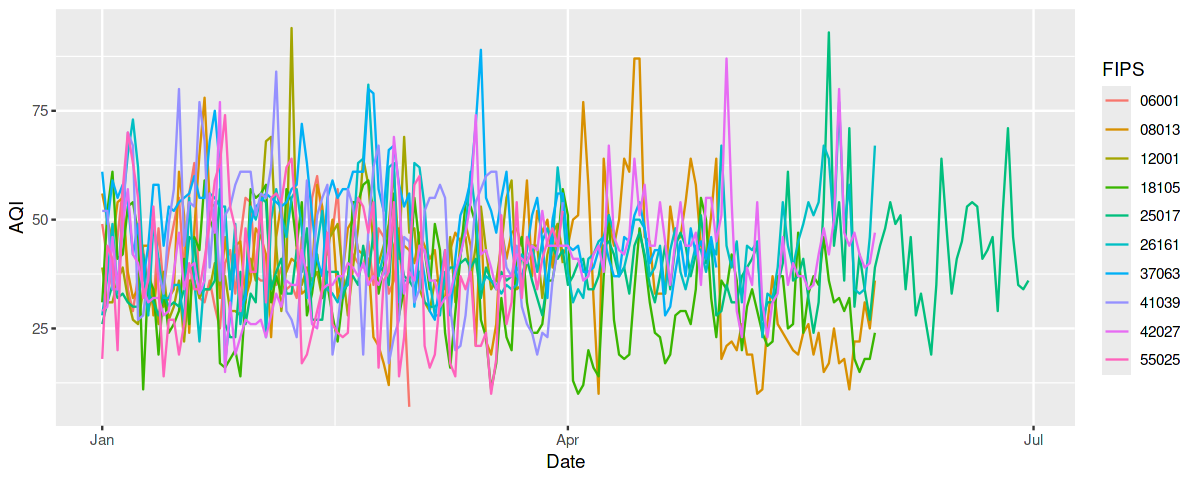

In [142]:
daily_aqi %>% 
    semi_join(counties_10) %>%
    filter(year(Date) == 2024) %>% 
    group_by(FIPS, Date) %>% summarize(AQI = mean(AQI, na.rm = T)) %>%
    ggplot + geom_line(aes(x = Date, y = AQI, group = FIPS, color = FIPS))

Joining with `by = join_by(FIPS)`
`summarise()` has grouped output by 'FIPS'. You can override using the `.groups` argument.


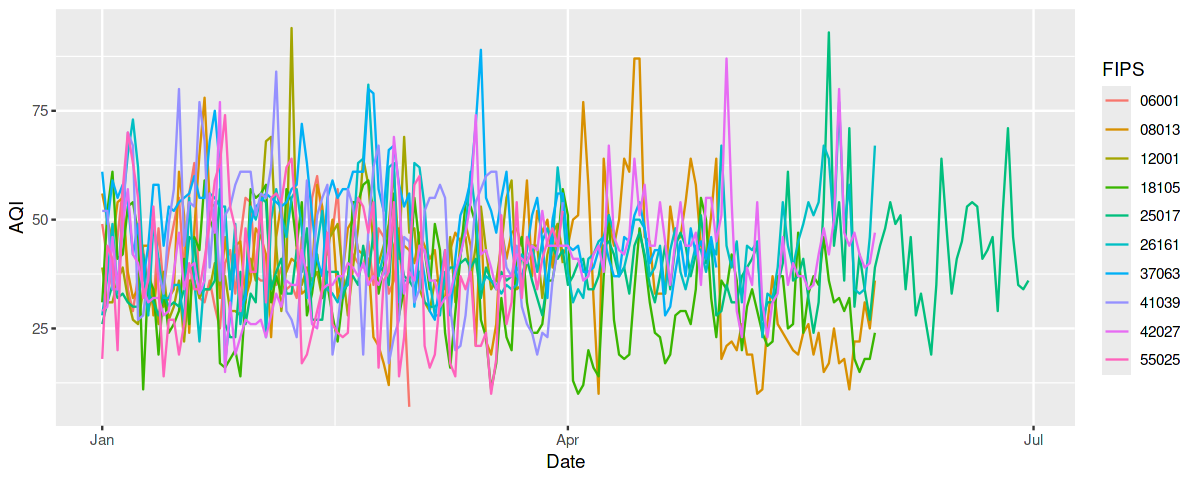

In [136]:
library(slider)

daily_aqi %>% 
    semi_join(counties_10) %>%
    filter(year(Date) == 2024) %>% 
    group_by(FIPS, Date) %>% summarize(AQI = mean(AQI, na.rm = T)) %>%
    group_by(FIPS) %>% 
    mutate(smAQI = slide_dbl(AQI, mean, .before=100, .after=100)) %>% 
    ggplot + geom_line(aes(x = Date, y = AQI, group = FIPS, color = FIPS))

In [143]:
daily_aqi %>% 
    semi_join(counties_10) %>%
    count(FIPS)

Joining with `by = join_by(FIPS)`


FIPS,n
<chr>,<int>
06001,1522
08013,1613
12001,1548
18105,1571
25017,1643
26161,1613
37063,1576
41039,1552
42027,1613
